In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Insulator",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 889 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['Damaged-insulator', 'Healthy-insulator']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1]


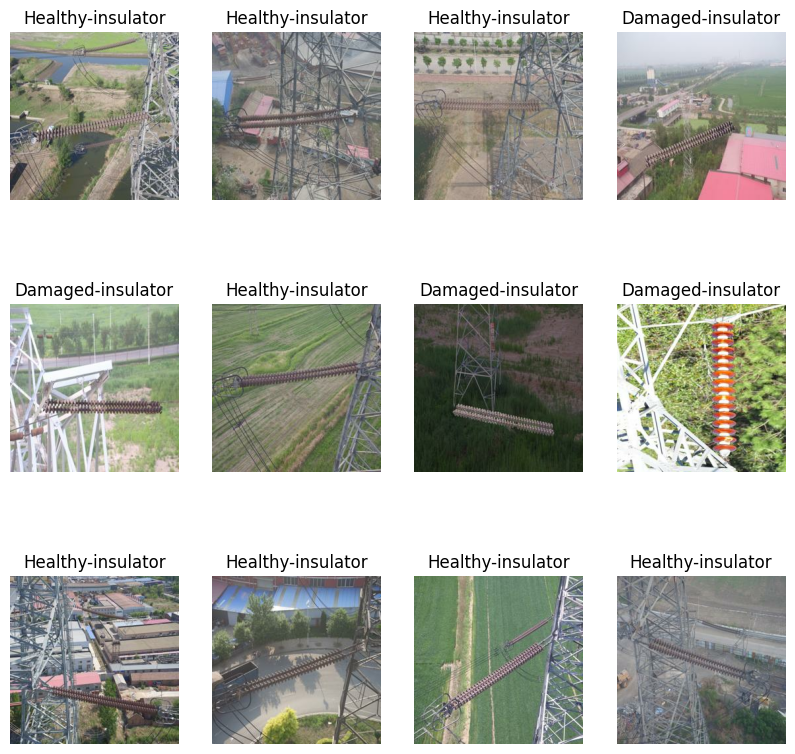

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

28

In [13]:
train_size = 0.8
len(dataset)*train_size

22.400000000000002

In [14]:
train_ds = dataset.take(22)
len(train_ds)

22

In [15]:
test_ds = dataset.skip(22)
len(test_ds)

6

In [16]:
val_size=0.1
len(dataset)*val_size

2.8000000000000003

In [17]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [18]:
test_ds = test_ds.skip(2)
len(test_ds)

4

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

22

In [22]:
len(val_ds)

2

In [23]:
len(test_ds)

4

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


22/22 [==============================] - 25s 882ms/step - loss: 0.6599 - accuracy: 0.6686 - val_loss: 0.6505 - val_accuracy: 0.6719
Epoch 2/50
22/22 [==============================] - 18s 809ms/step - loss: 0.6483 - accuracy: 0.6686 - val_loss: 0.6284 - val_accuracy: 0.6719
Epoch 3/50
22/22 [==============================] - 18s 813ms/step - loss: 0.5574 - accuracy: 0.7475 - val_loss: 0.5039 - val_accuracy: 0.7500
Epoch 4/50
22/22 [==============================] - 18s 810ms/step - loss: 0.5274 - accuracy: 0.7690 - val_loss: 0.5342 - val_accuracy: 0.7656
Epoch 5/50
22/22 [==============================] - 18s 817ms/step - loss: 0.5083 - accuracy: 0.7805 - val_loss: 0.5396 - val_accuracy: 0.7500
Epoch 6/50
22/22 [==============================] - 18s 806ms/step - loss: 0.5142 - accuracy: 0.7891 - val_loss: 0.5129 - val_accuracy: 0.7656
Epoch 7/50
22/22 [==============================] - 18s 816ms/step - loss: 0.5132 - accuracy: 0.7733 - val_loss: 0.5193 - val_accuracy: 0.76

In [32]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 2s 178ms/step - loss: 0.0642 - accuracy: 0.9688


In [33]:
scores

[0.06424541771411896, 0.96875]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 22}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6599075794219971,
 0.6482647061347961,
 0.5573897957801819,
 0.5274485349655151,
 0.5083320736885071]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

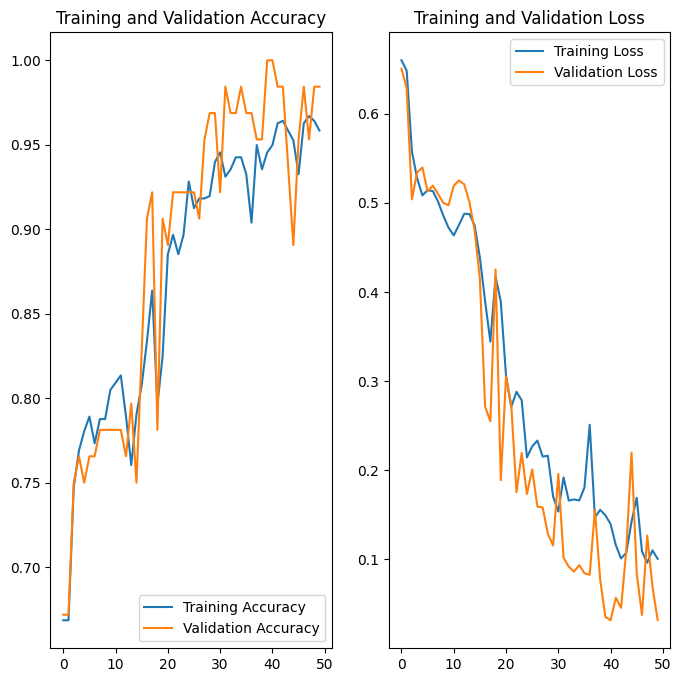

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy-insulator
1/1 [==============================] - 1s 630ms/step
predicted label: Healthy-insulator


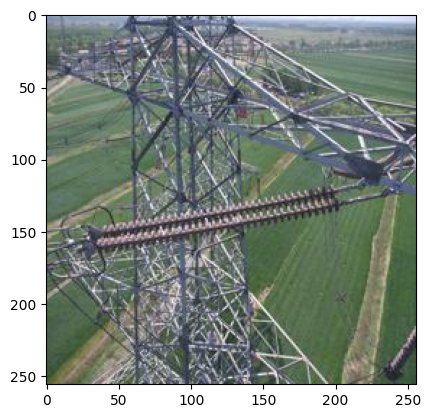

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


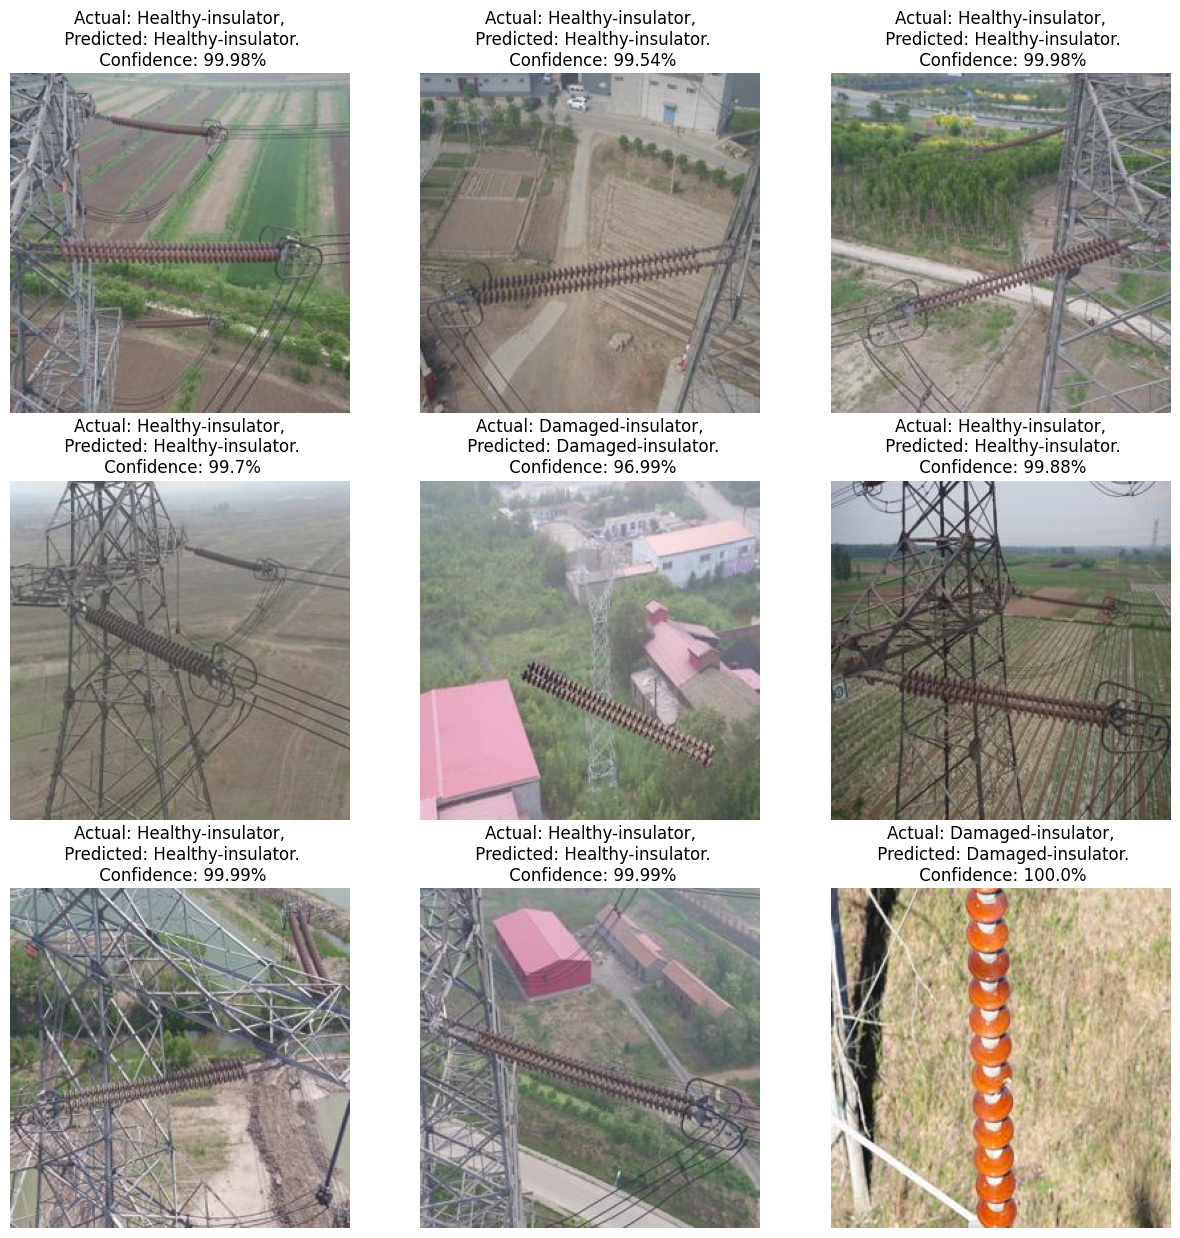

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 69ms/step


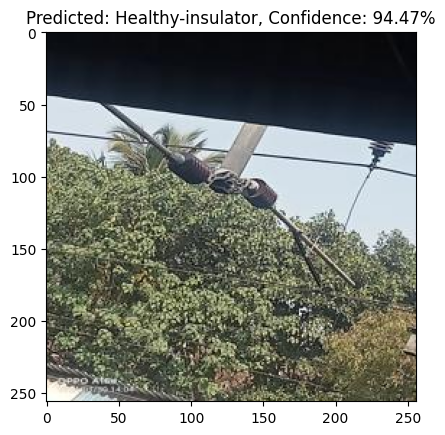

In [70]:

# Assuming you have defined test_ds, class_names, and model before this point

def load_and_preprocess_image(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(592, 900))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array


def predict_single_image(model, image_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Get predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

# Specify the path to the image you want to predict
image_path_to_predict = "C:\\Users\\cheta\\OneDrive\\Desktop\\output2\\IMG20240130140411.jpg"

# Make predictions for the single image
predicted_class, confidence = predict_single_image(model, image_path_to_predict)

# Display the image and prediction information
plt.figure()
img = tf.keras.preprocessing.image.load_img(image_path_to_predict)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}, Confidence: {confidence}%")
plt.show()


In [71]:
import os
model_version=max([int(i) for i in os.listdir("../saved-models") + [0]])+1
model.save(f"../saved-models/{model_version}")

INFO:tensorflow:Assets written to: ../saved-models/1\assets


INFO:tensorflow:Assets written to: ../saved-models/1\assets
